### Importing Important Libraries

# Tabular classification with Amazon SageMaker XGBoost and Scikit-learn Linear Learner algorithm
_**Making a Binary Prediction of Whether a Handwritten Digit is a 0**_

1. [Set Up](#1.-Set-Up)
2. [Train A Tabular Model on MNIST Dataset](#2.-Train-a-Tabular-Model-on-MNIST-Dataset)
    * [Retrieve Training Artifacts](#2.1.-Retrieve-Training-Artifacts)
    * [Set Training Parameters](#2.2.-Set-Training-Parameters)
    * [Train with Automatic Model Tuning](#2.3.-Train-with-Automatic-Model-Tuning)            
    * [Start Training](#2.4.-Start-Training)
3. [Deploy and Run Inference on the Trained Tabular Model](#3.-Deploy-and-Run-Inference-on-the-Trained-Tabular-Model)
4. [Evaluate the Prediction Results Returned from the Endpoint](#4.-Evaluate-the-Prediction-Results-Returned-from-the-Endpoint)

---
Để đào tạo và lưu trữ trên Amazon SageMaker, cần thiết lập và xác thực việc sử dụng các dịch vụ AWS. Ở đây,sử dụng vai trò thực thi được liên kết với  current notebook instance tài khoản AWS có quyền truy cập SageMaker. Nó có các quyền cần thiết, bao gồm quyền truy cập vào dữ liệu của bạn trong S3.

---

In [3]:
import sagemaker, boto3, json
from sagemaker import get_execution_role

aws_role = get_execution_role()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()
print(aws_region)

us-east-1


## 2. Train a Tabular Model on MNIST Dataset

---
In this demonstration, we will train a tabular algorithm on the
[MNIST](http://yann.lecun.com/exdb/mnist/) dataset. 
The dataset contains examples of individual pixel values from each 28 x 28 grayscale image to predict the digit label of 10 classes {0, 1, 2, 3, ..., 9}. The MNIST dataset is downloaded from [THE MNIST DATABASE](http://yann.lecun.com/exdb/mnist/). 

Below is the table of the first 5 examples in the MNIST dataset.

| Target | Feature_0 | Feature_1 | Feature_2 | ... | Feature_291 | Feature_293 | Feature_294 | ... | Feature_783 |  Feature_784  |
|:------:|:---------:|:---------:|:---------:|:---:|:-----------:|:-----------:|:-----------:|:---:|:-----------:|:-------------:|
|   7    |    0.0    |    0.0    |    0.0    | ... |   0.00000   |   0.25781   |   0.05469   | ... |     0.0     |      0.0      |
|   2    |    0.0    |    0.0    |    0.0    | ... |   0.00000   |   0.29687   |   0.96484   | ... |     0.0     |      0.0      |
|   1    |    0.0    |    0.0    |    0.0    | ... |   0.00000   |   0.00000   |   0.00000   | ... |     0.0     |      0.0      |
|   0    |    0.0    |    0.0    |    0.0    | ... |   0.98828   |   0.98046   |   0.98046   | ... |     0.0     |      0.0      |
|   4    |    0.0    |    0.0    |    0.0    | ... |   0.20703   |   0.00000   |   0.00000   | ... |     0.0     |      0.0      |


### 2.1. Retrieve Training Artifacts
---
Here, we retrieve the training docker container, the training algorithm source, and the tabular algorithm. Note that model_version="*" fetches the latest model.

In [5]:
from sagemaker import image_uris, model_uris, script_uris

train_model_id, train_model_version, train_scope = "xgboost-classification-model", "*", "training"

training_instance_type = "ml.m5.xlarge"

# Retrieve the docker image
train_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    model_id=train_model_id,
    model_version=train_model_version,
    image_scope=train_scope,
    instance_type=training_instance_type,
)
# Retrieve the training script
train_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope=train_scope
)
# Retrieve the pre-trained model tarball to further fine-tune
train_model_uri = model_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, model_scope=train_scope
)
print("done")

done


### 2.2. Set Training Parameters

In [6]:
# Sample training data is available in this bucket
training_data_bucket = f"jumpstart-cache-prod-{aws_region}"
training_data_prefix = "training-datasets/tabular_multiclass/"

training_dataset_s3_path = f"s3://{training_data_bucket}/{training_data_prefix}"

output_bucket = sess.default_bucket()
output_prefix = "jumpstart-example-tabular-training"

s3_output_location = f"s3://{output_bucket}/{output_prefix}/output"

### 2.4. Start Training

In [7]:
from sagemaker import hyperparameters

# Retrieve the default hyper-parameters for fine-tuning the model
hyperparameters = hyperparameters.retrieve_default(
    model_id=train_model_id, model_version=train_model_version
)

# [Optional] Override default hyperparameters with custom values
hyperparameters["num_boost_round"] = "500"  # this hyperparameter is speficially for XGBoost
hyperparameters["early_stopping_rounds"] = "5"  # this hyperparameter is speficially for XGBoost
print(hyperparameters)

{'num_boost_round': '500', 'early_stopping_rounds': '5', 'learning_rate': '0.3', 'gamma': '0', 'min_child_weight': '1', 'max_depth': '6', 'subsample': '1', 'colsample_bytree': '1', 'reg_lambda': '1', 'reg_alpha': '0'}


### 2.3. Train with Automatic Model Tuning  


Amazon SageMaker automatic model tuning, also known as hyperparameter tuning, finds the best version of a model by running many training jobs on your dataset using the algorithm and ranges of hyperparameters that you specify. It then chooses the hyperparameter values that result in a model that performs the best, as measured by a metric that you choose. We will use a HyperparameterTuner object to interact with Amazon SageMaker hyperparameter tuning APIs.

In [8]:
from sagemaker.tuner import ContinuousParameter, IntegerParameter, HyperparameterTuner

use_amt = True

if train_model_id == "xgboost-classification-model":

    hyperparameter_ranges = {
        "num_round": IntegerParameter(1000, 10000),
        "lambda": IntegerParameter(1, 50),
        "colsample_bytree": ContinuousParameter(0, 1),
        "alpha": IntegerParameter(1, 50),
        "subsample": ContinuousParameter(0, 1),
        "min_child_weight": IntegerParameter(1, 50),
        "max_delta_step": IntegerParameter(1, 50),
        "gamma": IntegerParameter(1, 50),
        "eta": ContinuousParameter(0.01, 1, scaling_type="Logarithmic"),
        "max_depth": IntegerParameter(1, 10),
    }


elif train_model_id == "sklearn-classification-linear":

    hyperparameter_ranges = {
        "alpha": ContinuousParameter(1e-6, 1, scaling_type="Logarithmic"),
        "tol": ContinuousParameter(1e-6, 1e-1, scaling_type="Logarithmic"),
        "l1_ratio": ContinuousParameter(0, 1),
    }

### 2.4. Start Training
---
We start by creating the estimator object with all the required assets and then launch the training job.

---

In [9]:
from sagemaker.estimator import Estimator
from sagemaker.utils import name_from_base

training_job_name = name_from_base(f"jumpstart-{train_model_id}-training")

# Create SageMaker Estimator instance
tabular_estimator = Estimator(
    role=aws_role,
    image_uri=train_image_uri,
    source_dir=train_source_uri,
    model_uri=train_model_uri,
    entry_point="transfer_learning.py",
    instance_count=1,
    instance_type=training_instance_type,
    max_run=360000,
    hyperparameters=hyperparameters,
    output_path=s3_output_location,
)

if use_amt:
    if train_model_id == "xgboost-classification-model":

        tuner = HyperparameterTuner(
            tabular_estimator,
            "validation:mlogloss",
            hyperparameter_ranges,
            max_jobs=2,
            max_parallel_jobs=2,
            objective_type="Minimize",
            base_tuning_job_name=training_job_name,
        )

    elif train_model_id == "sklearn-classification-linear":

        tuner = HyperparameterTuner(
            tabular_estimator,
            "accuracy_score",
            hyperparameter_ranges,
            [{"Name": "accuracy_score", "Regex": "accuracy_score: ([0-9\\.]+)"}],
            max_jobs=10,
            max_parallel_jobs=2,
            objective_type="Maximize",
            base_tuning_job_name=training_job_name,
        )

    tuner.fit({"training": training_dataset_s3_path}, logs=True)
else:
    # Launch a SageMaker Training job by passing s3 path of the training data
    tabular_estimator.fit(
        {"training": training_dataset_s3_path}, logs=True, job_name=training_job_name
    )
print("done")

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


...........................................................................................................................!
done


## 3. Deploy and Run Inference on the Trained Tabular Model

---
In this section, you learn how to query an existing endpoint and make predictions of the examples you input. For each example, the model will output the probability of the sample for each class in the model. 
Next, the predicted class label is obtained by taking the class label with the maximum probability over others. Throughout the notebook, the examples are taken from the [MNIST](http://yann.lecun.com/exdb/mnist/) test set. 
The dataset contains examples of individual pixel values from each 28 x 28 grayscale image to predict the digit label of 10 classes {0, 1, 2, 3, ..., 9}.

We start by retrieving the artifacts and deploy the `tabular_estimator` that we trained.

---

In [10]:
inference_instance_type = "ml.m5.large"

# Retrieve the inference docker container uri
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    image_scope="inference",
    model_id=train_model_id,
    model_version=train_model_version,
    instance_type=inference_instance_type,
)
# Retrieve the inference script uri
deploy_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope="inference"
)

endpoint_name = name_from_base(f"jumpstart-example-{train_model_id}-")

# Use the estimator from the previous step to deploy to a SageMaker endpoint
predictor = (tuner if use_amt else tabular_estimator).deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    entry_point="inference.py",
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    endpoint_name=endpoint_name,
    enable_network_isolation=True,
)
print("done")


2022-11-30 15:08:32 Starting - Preparing the instances for training
2022-11-30 15:08:32 Downloading - Downloading input data
2022-11-30 15:08:32 Training - Training image download completed. Training in progress.
2022-11-30 15:08:32 Uploading - Uploading generated training model
2022-11-30 15:08:32 Completed - Resource retained for reuse
------!done


---
Next, we download a hold-out MNIST test data from the S3 bucket for inference.

---

In [11]:
jumpstart_assets_bucket = f"jumpstart-cache-prod-{aws_region}"
test_data_prefix = "training-datasets/tabular_multiclass/test"
test_data_file_name = "data.csv"

boto3.client("s3").download_file(
    jumpstart_assets_bucket, f"{test_data_prefix}/{test_data_file_name}", test_data_file_name
)

---
Next, we read the MNIST test data into pandas data frame, prepare the ground truth target and predicting features to send into the endpoint. 

Below is the screenshot of the first 5 examples in the MNIST test set. All of the test examples with features 
from ```Feature_1``` to ```Feature_784``` are sent into the deployed model to get model predictions, 
to estimate the ground truth ```Target``` column. For each test example, the model will output 
a vector of ```num_classes``` elements, where each element is the probability of the example for each class in the model. 
The ```num_classes``` is 10 in this case. Next, the predicted class label is obtained by taking the class label 
with the maximum probability over others. 

---

In [12]:
newline, bold, unbold = "\n", "\033[1m", "\033[0m"

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# read the data
test_data = pd.read_csv(test_data_file_name, header=None)
test_data.columns = ["Target"] + [f"Feature_{i}" for i in range(1, test_data.shape[1])]

num_examples, num_columns = test_data.shape
print(
    f"{bold}The test dataset contains {num_examples} examples and {num_columns} columns.{unbold}\n"
)

# prepare the ground truth target and predicting features to send into the endpoint.
ground_truth_label, features = test_data.iloc[:, :1], test_data.iloc[:, 1:]

print(f"{bold}The first 5 observations of the data: {unbold} \n")
test_data.head(5)

The test dataset contains 10000 examples and 785 columns.

The first 5 observations of the data:  



,Target,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_775,Feature_776,Feature_777,Feature_778,Feature_779,Feature_780,Feature_781,Feature_782,Feature_783,Feature_784
0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


---
The following code queries the endpoint you have created to get the prediction for each test example. 
The `query_endpoint()` function returns a array-like of shape (num_examples, num_classes), where each row indicates 
the probability of the example for each class in the model. The num_classes is 10 in above test data. 
Next, the predicted class label is obtained by taking the class label with the maximum probability over others for each example. 

---

In [13]:
content_type = "text/csv"


def query_endpoint(encoded_tabular_data):
    client = boto3.client("runtime.sagemaker")
    response = client.invoke_endpoint(
        EndpointName=endpoint_name, ContentType=content_type, Body=encoded_tabular_data
    )
    return response


def parse_response(query_response):
    model_predictions = json.loads(query_response["Body"].read())
    predicted_probabilities = model_predictions["probabilities"]
    return np.array(predicted_probabilities)


# split the test data into smaller size of batches to query the endpoint due to the large size of test data.
batch_size = 1500
predict_prob = []
for i in np.arange(0, num_examples, step=batch_size):
    query_response_batch = query_endpoint(
        features.iloc[i : (i + batch_size), :].to_csv(header=False, index=False).encode("utf-8")
    )
    predict_prob_batch = parse_response(query_response_batch)  # prediction probability per batch
    predict_prob.append(predict_prob_batch)


predict_prob = np.concatenate(predict_prob, axis=0)
predict_label = np.argmax(
    predict_prob, axis=1
)  # Note. For binary classification, the model returns a array-like of shape (num_examples, 1),
# where each row is the probability of the positive label 1, assuming there are positive label (encoded as 1) and negative label (encoded as 0) in the target.
# To get the probability for both label 0 and 1, execute following code:
# predict_prob = np.vstack((1.0 - predict_prob, predict_prob)).transpose()

## 4. Evaluate the Prediction Results Returned from the Endpoint

---
We evaluate the predictions results returned from the endpoint by following two ways.

* Visualize the predictions results by plotting the confusion matrix.

* Measure the prediction results quantitatively.

---

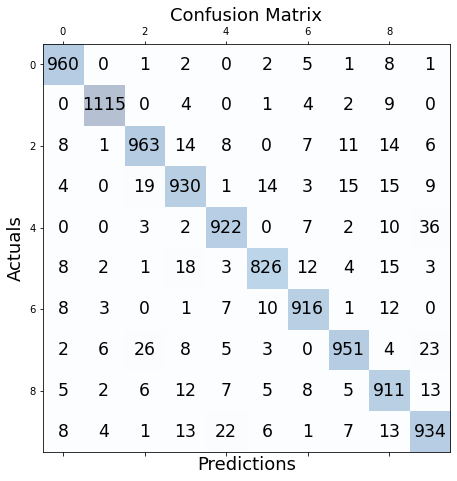

In [14]:
# Visualize the predictions results by plotting the confusion matrix.
conf_matrix = confusion_matrix(y_true=ground_truth_label.values, y_pred=predict_label)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i, s=conf_matrix[i, j], va="center", ha="center", size="xx-large")

plt.xlabel("Predictions", fontsize=18)
plt.ylabel("Actuals", fontsize=18)
plt.title("Confusion Matrix", fontsize=18)
plt.show()

## Set up hosting for the model

In [15]:
# Measure the prediction results quantitatively.
eval_accuracy = accuracy_score(ground_truth_label.values, predict_label)
eval_f1_macro = f1_score(ground_truth_label.values, predict_label, average="macro")
eval_f1_micro = f1_score(ground_truth_label.values, predict_label, average="micro")

print(
    f"{bold}Evaluation result on test data{unbold}:{newline}"
    f"{bold}{accuracy_score.__name__}{unbold}: {eval_accuracy}{newline}"
    f"{bold}F1 Macro{unbold}: {eval_f1_macro}{newline}"
    f"{bold}F1 Micro{unbold}: {eval_f1_micro}{newline}"
)

Evaluation result on test data:
accuracy_score: 0.9428
F1 Macro: 0.9423309410551074
F1 Micro: 0.9428



---
Next, we delete the endpoint corresponding to the finetuned model.

---

In [16]:
# Delete the SageMaker endpoint and the attached resources
predictor.delete_model()
predictor.delete_endpoint()